In [10]:
import os,cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [20]:
path = "Images"
annot = "Airplanes_Annotations"

In [21]:
for e,i in enumerate(os.listdir(annot)):
    filename = i.split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    plt.imshow(img)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

42845.jpg


In [13]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [14]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
train_images=[]
train_labels=[]

In [8]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if e > 200:
            break
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

In [9]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [10]:
X_new.shape

(8154, 224, 224, 3)

In [11]:
from keras.layers import Dense
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [12]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [14]:
X = vggmodel.layers[-2].output

In [15]:
predictions = Dense(2, activation="softmax")(X)

input1 = keras.Input(shape=(1,))
input2 = keras.Input(shape=(1,))

In [16]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [17]:
from keras.optimizers import adam_v2
opt = adam_v2.Adam(lr=0.0001)

C:\Users\sergi\PycharmProjects\ML\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [19]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [21]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [22]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [23]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [24]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7338, 224, 224, 3) (816, 224, 224, 3) (7338, 2) (816, 2)


In [25]:
dataGen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = dataGen.flow(x=X_train, y=y_train)
test_data = dataGen.flow(x=X_test,y=y_test)

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
checkpoint = ModelCheckpoint("cnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [28]:
hist = model_final.fit_generator(generator= train_data, steps_per_epoch= 10, epochs= 5, validation_data= test_data, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\sergi\AppData\Local\Temp\ipykernel_11140\3059104567.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= train_data, steps_per_epoch= 10, epochs= 5, validation_data= test_data, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.8756 - accuracy: 0.7563
Epoch 1: val_loss improved from inf to 0.52296, saving model to cnn_vgg16_1.h5
10/10 [==============================] - 127s 12s/step - loss: 0.8756 - accuracy: 0.7563 - val_loss: 0.5230 - val_accuracy: 0.7812
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9000
Epoch 2: val_loss improved from 0.52296 to 0.47772, saving model to cnn_vgg16_1.h5
10/10 [==============================] - 115s 12s/step - loss: 0.2708 - accuracy: 0.9000 - val_loss: 0.4777 - val_accuracy: 0.7812
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.9000
Epoch 3: val_loss improved from 0.47772 to 0.23330, saving model to cnn_vgg16_1.h5
10/10 [==============================] - 110s 11s/step - loss: 0.2730 - accuracy: 0.9000 - val_loss: 0.2333 - val_accuracy: 0.9219
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.1391 - accurac

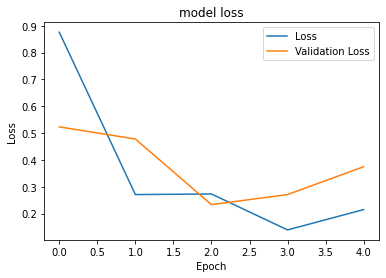

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [30]:
def show_img_with_airplanes_detection(img_path:str):
        img = cv2.imread(img_path)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()

        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.80:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

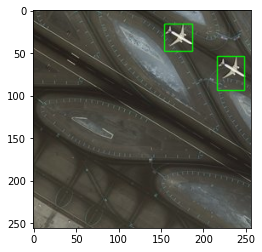

In [31]:
show_img_with_airplanes_detection('Images/428481.jpg')

## Использование обученных моделей с TensorFlow API

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
ssd_model = 'trained_models/ssd.pb'
faster_rcnn_model = "trained_models/faster_r-cnn.pb"
mask_rcnn_model = "trained_models/mask_r-cnn.pb"

In [3]:
def get_img_with_detections(model_path, image_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.compat.v1.GraphDef()
      with tf.io.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    image = Image.open(image_path)
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

    with detection_graph.as_default():
        with tf.Session() as sess:
          ops = tf.get_default_graph().get_operations()
          all_tensor_names = {output.name for op in ops for output in op.outputs}
          tensor_dict = {}
          for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
          if 'detection_masks' in tensor_dict:
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)

          image_tensor = tf.get_default_graph().get_tensor_by_name("image_tensor" + ':0')


          # Запуск поиска объектов на изображении
          output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image_np, 0)})

          # Преобразуем выходные тензоры типа float32 в нужный формат
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
          if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]

    label_map = label_map_util.load_labelmap('object_detection/data/mscoco_label_map.pbtxt')
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=(24, 16))
    plt.imshow(image_np)



In [11]:
image_file_name = r"C:\Users\sergi\Downloads\street.jpeg"

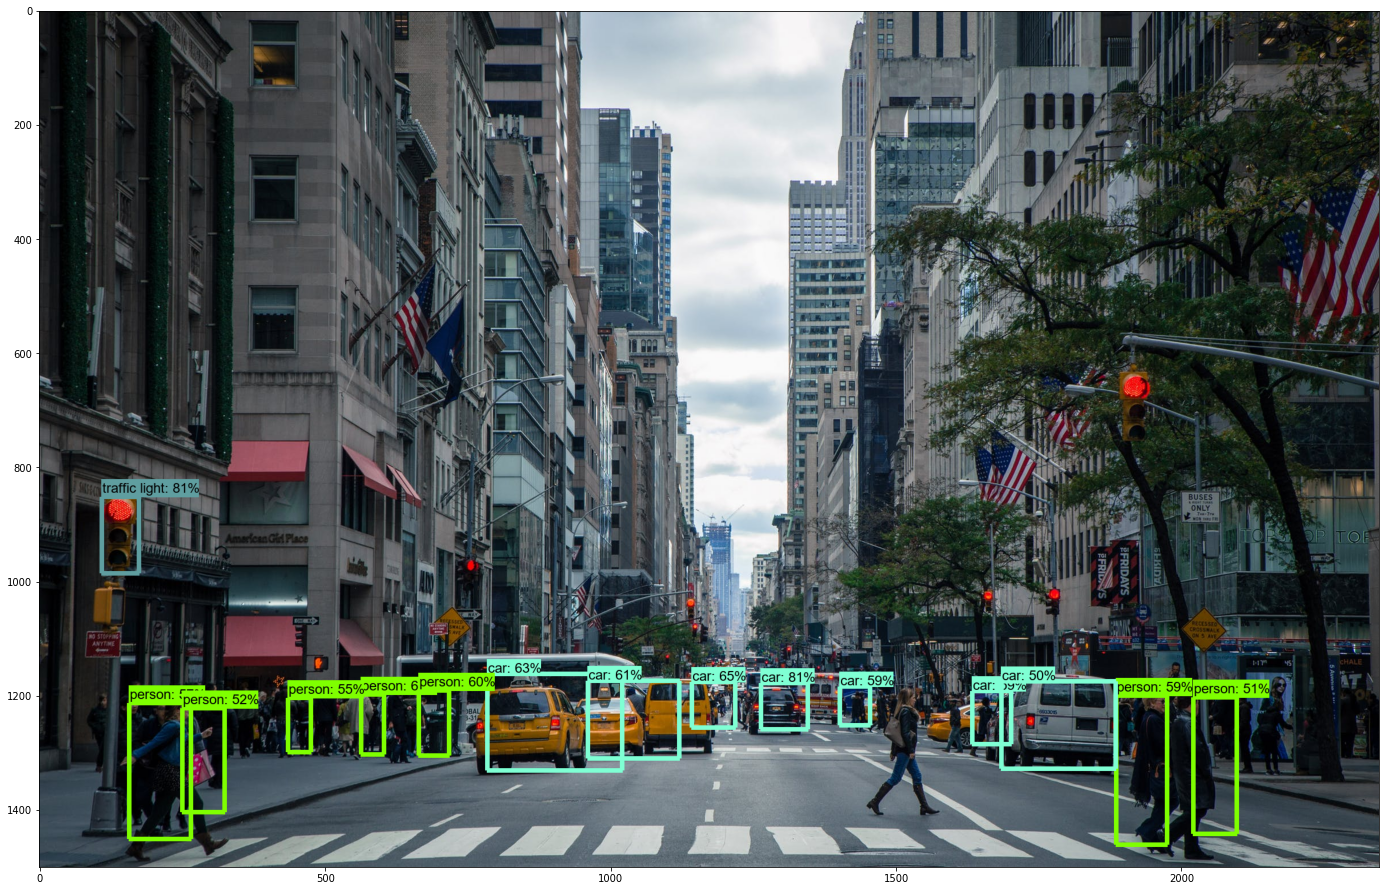

In [12]:
get_img_with_detections(ssd_model, image_file_name)

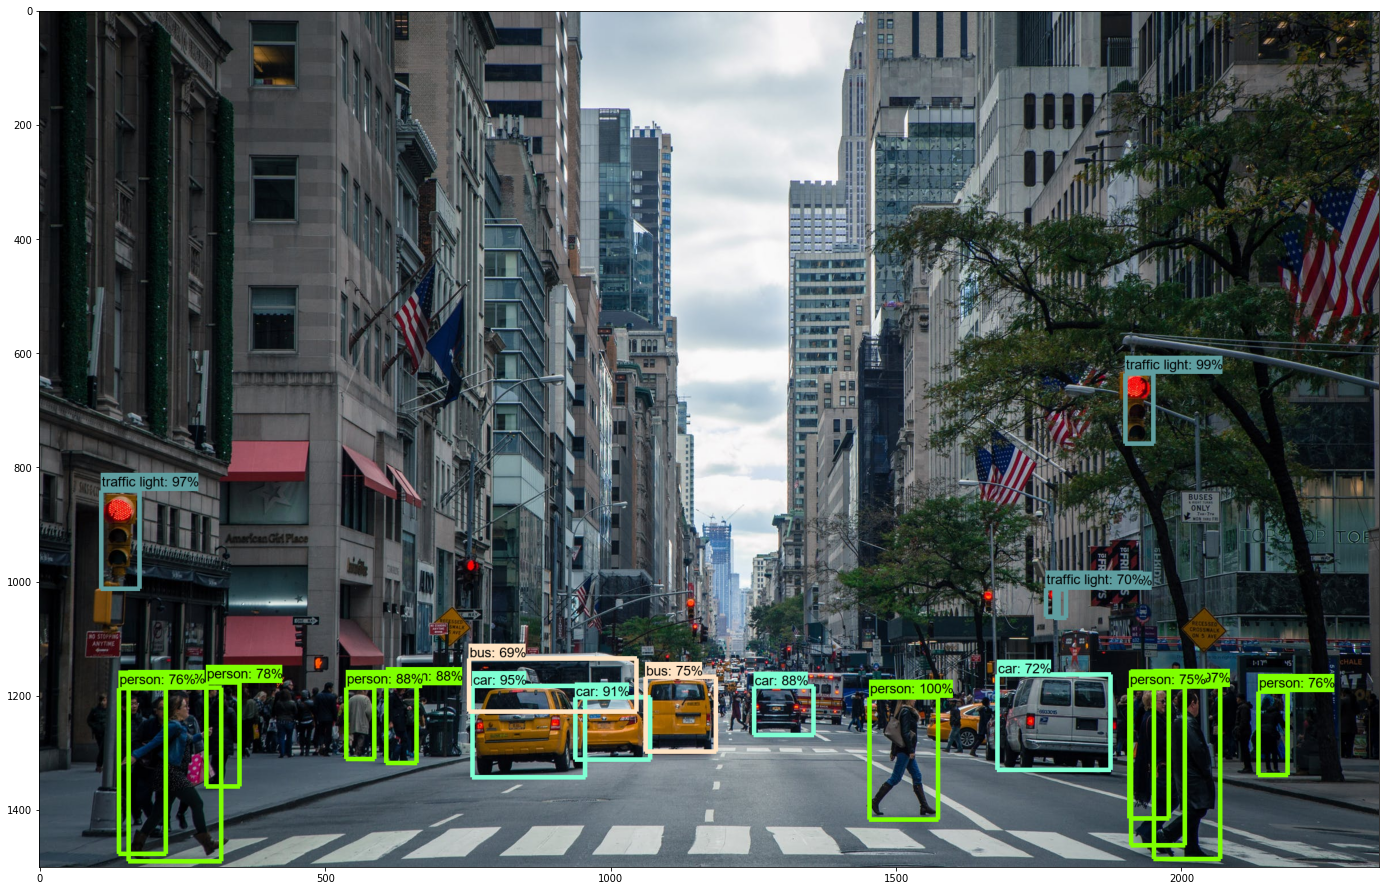

In [13]:
get_img_with_detections(faster_rcnn_model, image_file_name)

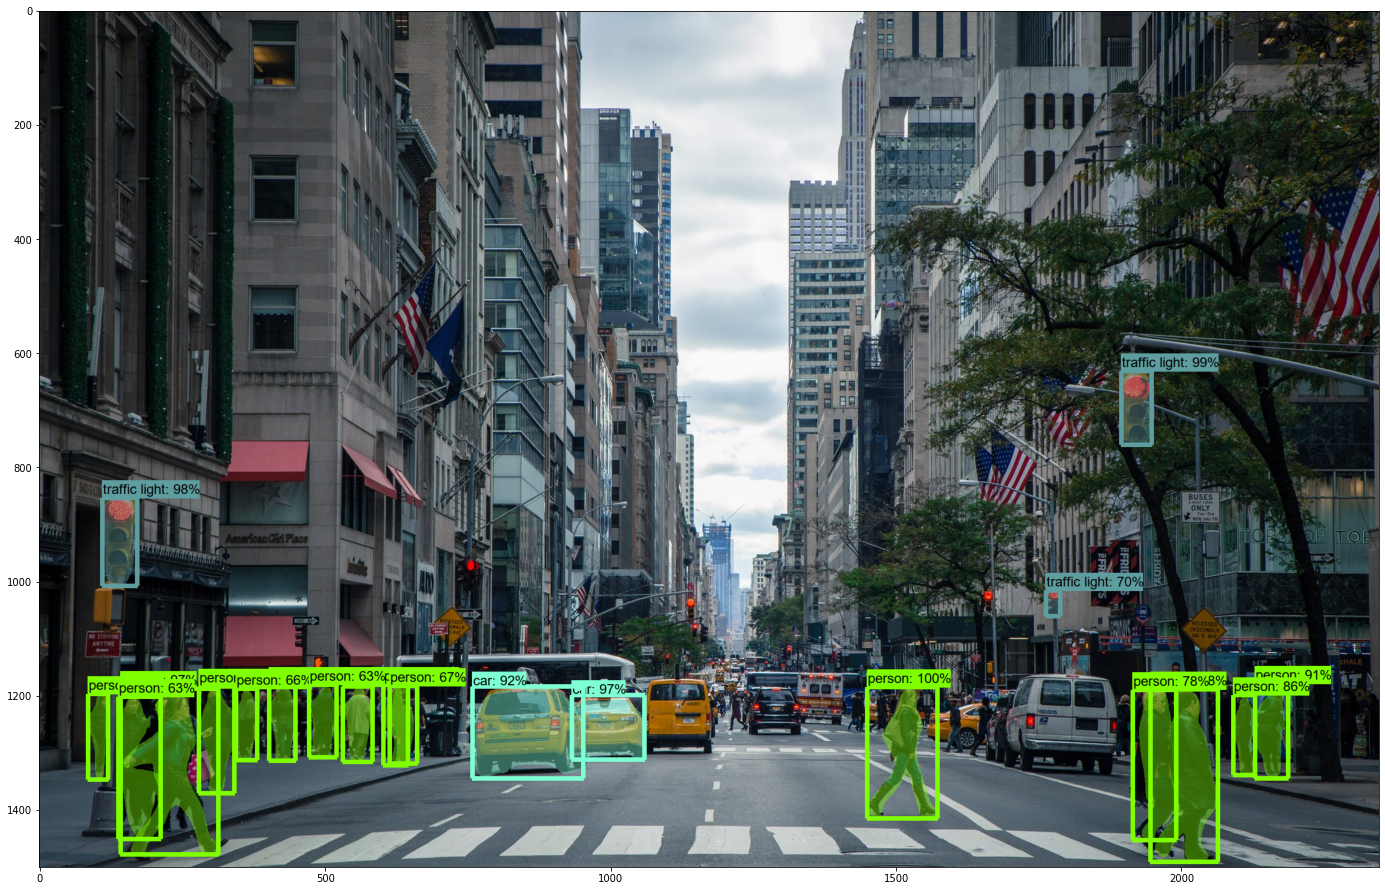

In [14]:
get_img_with_detections(mask_rcnn_model, image_file_name)